# Tetra-Tagging: Training

One of the advantages of the tetra-tagging formulation of constituency parsing is that it can quickly be applied on top of any architecture that is capable of making labeling decisions at each word. In this notebook, we'll be using the DistilBert architecture, implemented in pytorch as part of the Transformers library. However, the techniques here apply to any architecture type or choice of hardware.

On the GPU Colab instance I'm using, this parser achieves 93+ development F1 in as little as 15 minutes of training.

## Setup

In [2]:
%%capture
!pip install --upgrade nltk svgling torch tqdm
!pip install transformers==3.0.1

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import transformers
import tqdm.notebook

# We use NLTK for loading and working with parse tree data structures
import nltk
from nltk.corpus.reader.bracket_parse import BracketParseCorpusReader

# svgling lets us render parse trees in the browser
import svgling
svgling.disable_nltk_png()

Before proceeding, let's verify that we're connected to a GPU runtime and that `torch` can detect the GPU.

In [3]:
assert torch.cuda.is_available()
device = torch.device("cuda")
print("Using device:", device)

Using device: cuda


## Data

The code below downloads the standard Penn Treebank data splits for parsing: sections 2-21 are used for training, section 22 for validation, and section 23 for testing. We also download and build a copy of EVALB, the standard tool for computing parser F-scores.

In [4]:
%%bash
if [ ! -e self-attentive-parser ]; then
  git clone https://github.com/nikitakit/self-attentive-parser &> /dev/null
fi
rm -rf train dev test EVALB/
cp self-attentive-parser/data/02-21.10way.clean ./train
cp self-attentive-parser/data/22.auto.clean ./dev
cp self-attentive-parser/data/23.auto.clean ./test
# The evalb program needs to be compiled
cp -R self-attentive-parser/EVALB EVALB
cd EVALB && make &> /dev/null
# To test that everything works as intended, we check that the F1 score when
# comparing the dev set with itself is 100.
./evalb -p nk.prm ../dev ../dev | grep FMeasure | head -n 1

Bracketing FMeasure       = 100.00


Let's take a look at the format of the data:

In [5]:
!head -n 2 train

(TOP (S (PP (IN In) (NP (NP (DT an) (NNP Oct.) (CD 19) (NN review)) (PP (IN of) (NP (`` ``) (NP (DT The) (NN Misanthrope)) ('' '') (PP (IN at) (NP (NP (NNP Chicago) (POS 's)) (NNP Goodman) (NNP Theatre))))) (PRN (-LRB- -LRB-) (`` ``) (S (NP (JJ Revitalized) (NNS Classics)) (VP (VBP Take) (NP (DT the) (NNP Stage)) (PP (IN in) (NP (NNP Windy) (NNP City))))) (, ,) ('' '') (NP (NNP Leisure) (CC &) (NNP Arts)) (-RRB- -RRB-)))) (, ,) (NP (NP (NP (DT the) (NN role)) (PP (IN of) (NP (NNP Celimene)))) (, ,) (VP (VBN played) (PP (IN by) (NP (NNP Kim) (NNP Cattrall)))) (, ,)) (VP (VBD was) (VP (ADVP (RB mistakenly)) (VBN attributed) (PP (TO to) (NP (NNP Christina) (NNP Haag))))) (. .)))
(TOP (S (NP (NNP Ms.) (NNP Haag)) (VP (VBZ plays) (NP (NNP Elianti))) (. .)))


The files include one tree per line. We'll use the `BracketParseCorpusReader` from `nltk` to load the data.

In [6]:
READER = BracketParseCorpusReader('.', ['train', 'dev', 'test'])

## Tetra-Tagging

All code needed for the tetra-tagging system is contained in the single file, `tetra_tag.py`, that depends only on `numpy` and `nltk`.

In [7]:
![ ! -e tetra_tag.py ] && wget https://raw.githubusercontent.com/nikitakit/tetra-tagging/master/tetra_tag.py
import tetra_tag

--2020-07-06 10:59:54--  https://raw.githubusercontent.com/nikitakit/tetra-tagging/master/tetra_tag.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14918 (15K) [text/plain]
Saving to: ‘tetra_tag.py’

tetra_tag.py        100%[===================>]  14.57K  --.-KB/s    in 0.001s  

2020-07-06 10:59:54 (15.6 MB/s) - ‘tetra_tag.py’ saved [14918/14918]



This public API of this file consists of two classes: `TetraTagSequence` and `TetraTagSystem`.

`TetraTagSequence` encodes a sequence of tags, and has methods for converting between tag sequences and `nltk.Tree` objects.

Let's start with an example tree.

(TOP
  (S
    (NP (PRP She))
    (VP (VBZ enjoys) (S (VP (VBG playing) (NP (NN tennis)))))
    (. .)))


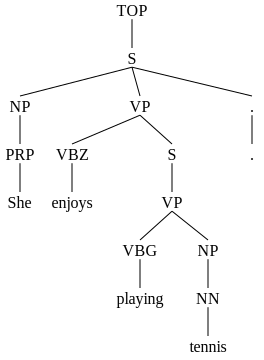

In [8]:
example_tree = nltk.Tree.fromstring("(TOP (S (NP (PRP She)) (VP (VBZ enjoys) (S (VP (VBG playing) (NP (NN tennis))))) (. .)))")
print(example_tree)
example_tree

The `TetraTagSequence.from_tree` class method allows creating tag sequences from trees. 

In [9]:
tetra_tag.TetraTagSequence.from_tree(example_tree)

['l/NP', 'L/S', 'l', 'L/VP', 'l', 'R/S/VP', 'r/NP', 'R', 'r']

Tag sequences can also be created from lists.

In [10]:
example_tags = tetra_tag.TetraTagSequence(
    ['l/NP', 'L/S', 'l', 'L/VP', 'l', 'R/S/VP', 'r/NP', 'R', 'r'])
example_tags

['l/NP', 'L/S', 'l', 'L/VP', 'l', 'R/S/VP', 'r/NP', 'R', 'r']

The `TetraTagSequence` class inherits from `list`, but it also has an additional `to_tree` method. When creating a tree from a tag sequence, leaf nodes must be passed in because the tag sequence doesn't contain the actual words in a sentence, nor their part of speech tags.

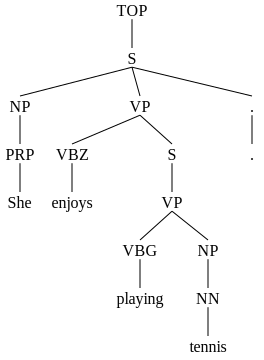

In [11]:
leaf_nodes=[nltk.Tree(tag, [word]) for word, tag in example_tree.pos()]
example_tags.to_tree(leaf_nodes)

The `TetraTagSystem` class keeps track of a tag vocabulary. In addition to methods for converting between trees and tags, it can also map tags to numerical ids, as well as find the highest-scoring tree given a table of logits for different tags.

A tag system can be initialized using either a tag vocabulary (via the `tag_vocab` argument), or by automatically creating a tag vocabulary given a treebank. Here is an example tag system:

In [12]:
example_tag_system = tetra_tag.TetraTagSystem(trees=[example_tree])
example_tag_system.tag_vocab

['L/S', 'L/VP', 'R', 'R/S/VP', 'l', 'l/NP', 'r', 'r/NP']

We see that the tag vocabulary is very limited and only contains the syntactic categories present in our example tree. Later on in this notebook, we'll use the full training dataset to construct our actual tag system.

With a `TetraTagSystem` object, we can map from trees to tag ids.

In [13]:
tag_ids = example_tag_system.ids_from_tree(example_tree)
tag_ids

[5, 0, 4, 1, 4, 3, 7, 2, 6]

We can also map in the opposite direction.

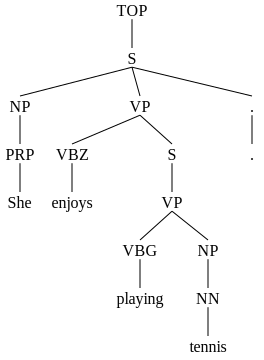

In [14]:
example_tag_system.tree_from_ids(tag_ids, pos=example_tree.pos())

## Input Pipeline

Next, let's define classes for an input pipeline that we can use with the HuggingFace trainer framework.

As part of this, we'll need some helper code to adjust some of the escape sequences used in the Penn Treebank data format.

In [15]:
BERT_TOKEN_MAPPING = {
    "-LRB-": "(",
    "-RRB-": ")",
    "-LCB-": "{",
    "-RCB-": "}",
    "-LSB-": "[",
    "-RSB-": "]",
    "``": '"',
    "''": '"',
    "`": "'",
    '«': '"',
    '»': '"',
    '‘': "'",
    '’': "'",
    '“': '"',
    '”': '"',
    '„': '"',
    '‹': "'",
    '›': "'",
    "\u2013": "--", # en dash
    "\u2014": "--", # em dash
    }

def ptb_unescape(sent):
  cleaned_words = []
  for word in sent:
      word = BERT_TOKEN_MAPPING.get(word, word)
      word = word.replace('\\/', '/').replace('\\*', '*')
      # Mid-token punctuation occurs in biomedical text
      word = word.replace('-LSB-', '[').replace('-RSB-', ']')
      word = word.replace('-LRB-', '(').replace('-RRB-', ')')
      if word == "n't" and cleaned_words:
          cleaned_words[-1] = cleaned_words[-1] + "n"
          word = "'t"
      cleaned_words.append(word)
  return cleaned_words

In [16]:
class TetraTaggingDataset(torch.utils.data.Dataset):
  def __init__(self, split, tokenizer, tag_system, pad_to_len=None,
               max_train_len=60):
    assert split in ('train', 'dev', 'test')
    self.trees = READER.parsed_sents(split)
    self.tokenizer = tokenizer
    self.tag_system = tag_system
    self.pad_token_id = self.tokenizer.pad_token_id
    self.pad_to_len = pad_to_len
    
    if split == 'train' and max_train_len is not None:
      # To speed up training, we only train on short sentences.
      self.trees = [
          tree for tree in self.trees if len(tree.leaves()) <= max_train_len]

  def __len__(self):
    return len(self.trees)

  def __getitem__(self, index):
    tree = self.trees[index]
    words = ptb_unescape(tree.leaves())
    encoded = tokenizer.encode_plus(' '.join(words))
    input_ids = torch.tensor(encoded['input_ids'], dtype=torch.long)
    word_end_positions = [
        encoded.char_to_token(i)
        for i in np.cumsum([len(word) + 1 for word in words]) - 2]

    tag_ids = self.tag_system.ids_from_tree(tree)

    # Pack both leaf and internal tag ids into a single "label" field.
    # (The huggingface API isn't flexible enough to use multiple label fields) 
    tag_ids = [tag_id + 1 for tag_id in tag_ids] + [0]
    tag_ids = torch.tensor(tag_ids, dtype=torch.long)
    labels = torch.zeros_like(input_ids)
    leaf_labels = tag_ids[::2] - self.tag_system.internal_tag_vocab_size
    internal_labels = tag_ids[1::2]
    labels[word_end_positions] = (
      internal_labels * (self.tag_system.leaf_tag_vocab_size + 1) + leaf_labels)

    if self.pad_to_len is not None:
      pad_amount = self.pad_to_len - input_ids.shape[0]
      assert pad_amount >= 0
      if pad_amount != 0:
        input_ids = F.pad(input_ids, [0, pad_amount], value=self.pad_token_id)   
        labels = F.pad(labels, [0, pad_amount], value=0)   

    return {'input_ids': input_ids, 'labels': labels}

  def collate(self, batch):
    input_ids = pad_sequence(
        [item['input_ids'] for item in batch],
        batch_first=True, padding_value=self.pad_token_id)
    labels = pad_sequence(
        [item['labels'] for item in batch],
        batch_first=True, padding_value=0)
    
    input_ids = input_ids.to(device)
    attention_mask = (input_ids != self.pad_token_id)
    labels = labels.to(device)
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels,
    }

## Model

Next, we need to define our model class. Token classification models almost work for our purposes, but we need a different training loss because there are two tagging decisions per word (one decision for a leaf node, and one decision for an internal node).

We base our model on DistilBert because it's really quick to fine-tune in the Colab environment.

In [17]:
class ModelForTetraTagging(transformers.DistilBertForTokenClassification):
  def __init__(self, config):
    super().__init__(config)
    self.num_leaf_labels = config.task_specific_params['num_leaf_labels']
    self.num_internal_labels = config.task_specific_params['num_internal_labels']

  def forward(
      self,
      input_ids=None,
      attention_mask=None,
      head_mask=None,
      inputs_embeds=None,
      labels=None,
      output_attentions=None,
      output_hidden_states=None,
  ):
    outputs = super().forward(
        input_ids,
        attention_mask=attention_mask,
        head_mask=head_mask,
        inputs_embeds=inputs_embeds,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
    )

    if labels is not None:
      logits = outputs[0]
      internal_logits, leaf_logits = torch.split(
        logits, [self.num_internal_labels, self.num_leaf_labels], dim=-1)
      internal_labels = (labels // (self.num_leaf_labels + 1)) - 1
      leaf_labels = (labels % (self.num_leaf_labels + 1)) - 1

      loss_fct = nn.CrossEntropyLoss(ignore_index=-1)
      # Only keep active parts of the loss
      if attention_mask is not None:
          active_loss = attention_mask.view(-1) == 1
          active_leaf_logits = leaf_logits.view(-1, self.num_leaf_labels)
          active_internal_logits = internal_logits.view(
              -1, self.num_internal_labels)
          active_leaf_labels = torch.where(
              active_loss, leaf_labels.view(-1),
              torch.tensor(loss_fct.ignore_index).type_as(leaf_labels)
          )
          active_internal_labels = torch.where(
              active_loss, internal_labels.view(-1),
              torch.tensor(loss_fct.ignore_index).type_as(internal_labels)
          )
          loss = (loss_fct(active_leaf_logits, active_leaf_labels)
                  + loss_fct(active_internal_logits, active_internal_labels))
      else:
          loss = (loss_fct(leaf_logits.view(-1, self.num_leaf_labels),
                           leaf_labels.view(-1))
                  + loss_fct(internal_logits.view(-1, self.num_internal_labels),
                           internal_labels.view(-1)))
      outputs = (loss,) + outputs

    return outputs  # (loss), scores, (hidden_states), (attentions)

Now, let's create our tag system, data pipeline, and model

In [18]:
tag_system = tetra_tag.TetraTagSystem(trees=READER.parsed_sents('train'))

In [19]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    'distilbert-base-uncased', use_fast=True)
assert tokenizer.is_fast, "Only fast tokenizers are supported by this notebook"

In [20]:
train_dataset = TetraTaggingDataset('train', tokenizer, tag_system)
# The Trainer framework we're using doesn't allow variable-length sequences at
# evaluation time, so we pad to length 256.
eval_dataset = TetraTaggingDataset('dev', tokenizer, tag_system, pad_to_len=256)

In [21]:
config = transformers.AutoConfig.from_pretrained(
    'distilbert-base-uncased',
    num_labels = len(tag_system.tag_vocab),
    id2label={i: label for i, label in enumerate(tag_system.tag_vocab)},
    label2id={label: i for i, label in enumerate(tag_system.tag_vocab)},
    task_specific_params = {
      'num_leaf_labels': tag_system.leaf_tag_vocab_size,
      'num_internal_labels': tag_system.internal_tag_vocab_size,
    }
)

model = ModelForTetraTagging.from_pretrained(
    'distilbert-base-uncased', config=config)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing ModelForTetraTagging: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing ModelForTetraTagging from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing ModelForTetraTagging from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ModelForTetraTagging were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to us

In [22]:
def compute_metrics(p, num_leaf_labels=tag_system.leaf_tag_vocab_size):
  """Computes accuracies for both leaf and internal tagging decisions.""" 
  leaf_predictions = p.predictions[..., -num_leaf_labels:]
  internal_predictions = p.predictions[..., :-num_leaf_labels]
  leaf_labels = p.label_ids % (num_leaf_labels + 1) - 1
  internal_labels = p.label_ids // (num_leaf_labels + 1) - 1

  leaf_predictions = leaf_predictions[leaf_labels != -1].argmax(-1)
  internal_predictions = internal_predictions[internal_labels != -1].argmax(-1)

  leaf_labels = leaf_labels[leaf_labels != -1]  
  internal_labels = internal_labels[internal_labels != -1]  
 
  return {
      'internal_accuracy': (internal_predictions == internal_labels).mean(),
      'leaf_accuracy': (leaf_predictions == leaf_labels).mean(),
      }

training_args = transformers.TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=160, 
    weight_decay=0.01, 
    logging_dir='./logs',
    save_steps=1149,
)

trainer = transformers.Trainer(
      model=model,
      args=training_args,
      train_dataset=train_dataset,
      data_collator=train_dataset.collate,
      eval_dataset=eval_dataset,
      compute_metrics=compute_metrics,
  )

In [23]:
## To monitor the training using Tensorboard, uncomment this code and run it
## before calling trainer.train() below.
# %load_ext tensorboard
# !rm -rf logs results
# %tensorboard --logdir logs

In [24]:
trainer.train()

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


TrainOutput(global_step=9912, training_loss=0.31669716444148366)

Having trained the parser, we can now evaluate it on the dev set. We can start by measing the accuracy for tagging decisions.

In [28]:
p = trainer.predict(eval_dataset)
p.metrics

{'eval_internal_accuracy': 0.9368769034541999,
 'eval_leaf_accuracy': 0.9800084752100107,
 'eval_loss': 0.30595456394884324}

The `TetraTagSystem` class defines an inference procedure for finding the highest-scoring tree given a tag sequence. This is a pure-Python reference implementation, so it will be moderately slow. (In the future, we plan to release our optimized Cython implementation, which is what we used for speed measurements in our paper.)

In [29]:
predicted_dev_trees = []
for i in range(p.predictions.shape[0]):
  logits = p.predictions[i]
  is_word = p.label_ids[i] != 0
  pos = eval_dataset.trees[i].pos()
  tree = tag_system.tree_from_logits(logits, is_word, pos=pos)
  predicted_dev_trees.append(tree)

We can now call EVALB to calculate bracketing recall, precision, and F1 score.

In [30]:
with open('./dev_predictions.txt', 'w') as f:
  for tree in predicted_dev_trees:
    f.write(' '.join(str(tree).split()) + '\n')

!EVALB/evalb -p EVALB/nk.prm dev dev_predictions.txt | tail -n 27 | head -n 12

-- All --
Number of sentence        =   1700
Number of Error sentence  =      0
Number of Skip  sentence  =      0
Number of Valid sentence  =   1700
Bracketing Recall         =  93.11
Bracketing Precision      =  93.29
Bracketing FMeasure       =  93.20
Complete match            =  49.35
Average crossing          =   0.48
No crossing               =  80.47
2 or less crossing        =  93.82


If your experience matched ours, the parser should have achieved over 93 F1 on the development set!

The parser presented in our paper achieves a higher score, but it also uses a significantly more expensive training procedure that takes longer to train and/or requires more hardware (such as the latest TPUs, which are not available in Colab). As a point of reference, here are the hyperparameters we used for the paper:

*   The architecture was `bert-large-uncased`
*   All training sentences were used (there was no length limit)
*   The batch size was 32, and sentences in each epoch were sampled without replacement
*   Weight decay was disabled, but gradient clipping remained at 1.0
*   The learning rate was warmed up to its base value of 3e-5 over the course of 160 training steps
*   Development F1 was measured 4 times per epoch, and the learning rate was cut in half whenever development F1 failed to improve.
*   After 3 consecutive decays with no improvement, training was terminated and the best checkpoint on the development set was selected.

